# Plots for my PhD Thesis

All those plots come from my different researches. The intention is to have them coherently designed.

### Required packages and Constants

In [2]:
using HDF5

In [13]:
using PyPlot

L_FSIZE = 16
T_FSIZE = 14
CMAP = "viridis"
CMAP_R = "viridis_r"
HG = 3.5 #inches
WD = 5 #inches
LWD = 1.5 #points

sys:1: PyGIWarning: Gtk was imported without specifying a version first. Use gi.require_version('Gtk', '3.0') before import to ensure that the right version gets loaded.


1.5

## Plot for accuracy bound in the vicinity of Dicke states

Those plots come from an analytical formula so the data is generated on the fly.

The magnetic field is along $Y$ direction, $H=\gamma J_y$

### Plot evolution

In [5]:
# Get Data
h5file = h5open("plotsData.h5")
data = h5file["VicinityDicke"]["PrecisionOverTheta"]

theta = read(data["theta"])
precision = read(data["precision"])

theta_max = read(attrs(data)["theta_max"])
precision_max = read(attrs(data)["precision_max"])

close(h5file)

Save the data

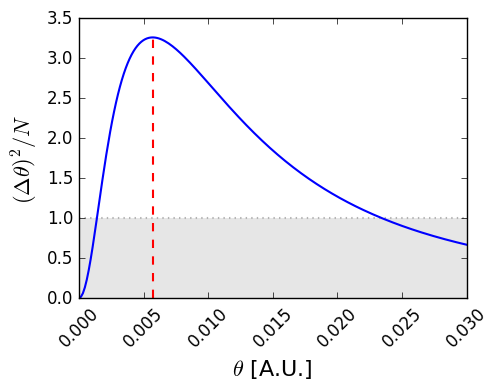

In [9]:
# Figure
fig = figure(figsize=(5,3.5))
xl = xlabel(L"$\theta$ [A.U.]", fontsize=L_FSIZE)
yl = ylabel(L"$(\Delta \theta)^2/N$", fontsize=L_FSIZE)
xticks(rotation=45)

ax = axis(xmin=minimum(theta), xmax=maximum(theta))

# SN thresold
bar(minimum(theta),1,maximum(theta),0, color="0.9", 
    edgecolor="0.7",linewidth=0)
plot([minimum(theta),maximum(theta)],
    [1,1], color="0.7", linewidth=LWD, linestyle="dotted")

plot([theta_max,theta_max],[0,precision_max],
    "--r", linewidth=LWD)
plt = plot(theta,precision,linewidth=LWD)


savefig("svg/VD_precision_theta.svg", bbox_inches="tight")

### Plot versus QFI of known states

### Plot contour

In [206]:
n = 7900
points = 500
x = Array(linspace(0,n*(n+2)/8,points))/(n*(n+2)/8)
y = Array(linspace(0,400,points))
z = (optprecision3(x*n*(n+2)/8,y,7900).^(-1)/n)'
z[1:end,1] = zeros(1,points)
ln = 15
map!(x -> if x > ln || isnan(x) 15 else x end,z);

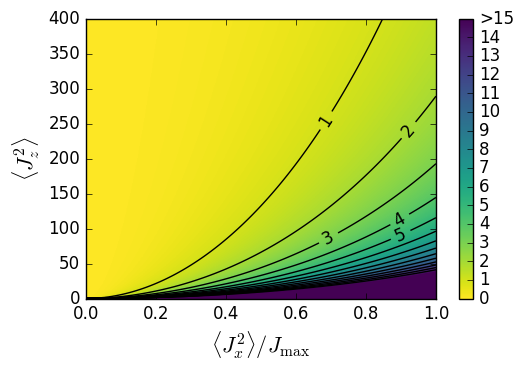

In [207]:
fig = figure(figsize=(6,3.5))

ylabel(L"$\langle J_z^2\rangle$", fontsize=L_FSIZE)
xlabel(L"$\langle J_x^2\rangle / J_{\rm max}$", fontsize=L_FSIZE)

im = imshow(z, cmap="viridis_r", interpolation="bilinear",
origin="lower", extent=[0,1,0,400], aspect=1/400*4/5)

c = contour(x,y,z,ln-1,colors="k")
clabel(c, fmt="%1.0f", manual=[(0.7,250),(0.9,250),(0.7,80),(0.9,110),(0.9,90)])
cb = colorbar(im, ticks=Array(0:ln))
cb[:ax][:set_yticklabels](vcat(map(string, Array(0:ln-1)),">$ln"))

savefig("svg/VD_contour.svg", bbox_inches="tight")

## Plots for the legendre transform.

Get image for the spin-squeezing bound from blender(c), still it is not possible to do this on matplotlib. This is because the smoothness needed at the border. Image file `data/LT_spsq2d_4.png`.

In [16]:
# Get Data
h5file = h5open("plotsData.h5")
dataGroup = h5file["OptimalBound"]["SpinSqueezing"]

precision = read(dataGroup["presision"])

XLim = read(attrs(dataGroup)["XLim"])
YLim = read(attrs(dataGroup)["YLim"])

2-element Array{Int64,1}:
 0
 4

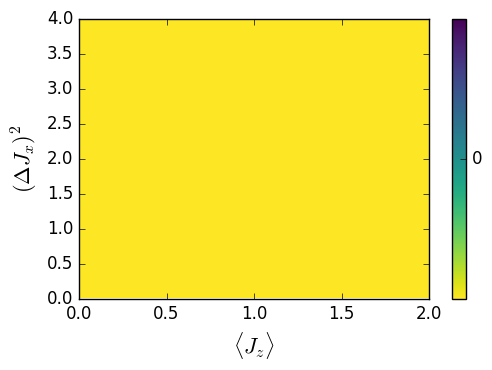

In [28]:
figure(figsize=(6,3.5))

xlabel(L"\langle J_z \rangle",fontsize=L_FSIZE)
ylabel(L"(\Delta J_x)^2",fontsize=L_FSIZE)

im = imshow(precision, cmap=CMAP_R ,aspect=1/2*4/5, extent=[0,2,0,4])
t_line = plot()

cb = colorbar(im, ticks=Array(linspace(0,1,4)))
cb[:ax][:set_yticklabels](vcat(map(string, Array(0:3)),">4"))

savefig("svg/LT_spsq2d_4.svg", bbox_inches="tight")

In [15]:
XLim

HDF5 attribute: XLim

In [21]:
close(h5file)

In [9]:
names(dataGroup)

1-element Array{ByteString,1}:
 "presision"

In [25]:
precision

1024×1024 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

  likely near /home/iapellaniz/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at 
  likely near /home/iapellaniz/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/iapellaniz/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /home/iapellaniz/.julia/v0.5/ZMQ/src/ZMQ.jl
  likely near /home/iapellaniz/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /home/iapellaniz/.julia/v0.5/ZMQ/src/ZMQ.jl
  likely near /home/iapellaniz/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /home/iapellaniz/.julia/v0.5/ZMQ/src/ZMQ.jl
